## Assignmnet Week 10

[MLFlow][1] is an open source framework used for MLOps which provides tools for development, tracking experiments, managing models and deployment.

In this assignment, MLFlow is used to capture and log below attributes from a OpenAI chat completion task (model used - gpt-4o-mini). User are promted to enter their query and then api call to OpenAI chat completion is initiated. After receiving the response from the OpenAI gpt-40-mini model, the below attributes and performance metrics are logged by the MLFlow logging capability.

- prompt tokens
- completion tokens
- conversation tokens
- request latency (time taken to send and receive response from OpenAI gpt model)
- request count (count of request sent to OpenAI)

Furthermore, the below parameters used in the OpenAI api call is also captured by MLFlow.

- Model used
- Temperature
- Top P
- Frequency Penalty
- Presency Penalty


[1]: https://mlflow.org/docs/latest/getting-started/intro-quickstart/index.html

Docker containers are used to run MLFlow server and the port used for MLFLow is 8080

In [1]:
import os
import time
import mlflow
from openai import OpenAI
import tiktoken as tk
from colorama import Fore, Style, init
import json
import warnings

warnings.filterwarnings('ignore')

As the mlflow is running locally on port 8080, the mlflow uri is `http://localhost:8080`

In [2]:
MLFLOW_URI = "http://localhost:8080"

Setting the Model parameters for Open API API call

In [3]:
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.7
TOP_P = 1
FREQUENCY_PENALTY = 0
PRESENCE_PENALTY = 0
MAX_TOKENS = 800
DEBUG = False

In [4]:
# Initialize colorama
init()

# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]

os.environ["OPENAI_API_KEY"] = api_key
# Initialize OpenAI client
client = OpenAI()

Need to set `tracking server` for MlFlow. For this execution, mlflow server is running locally and it is listening on port `8080`. Also need to provide an experiment name for mlflow to log model metadata and performance metrics.

In [5]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("week10_assignment") 

<Experiment: artifact_location='/mlflow/artifacts/260420388858552430', creation_time=1738956846799, experiment_id='260420388858552430', last_update_time=1738956846799, lifecycle_stage='active', name='week10_assignment', tags={}>

MlFlow `log_metric` method was used to log the performance metrics of OpenAI api call for chat completion task, and `log_params` method was used to log the parameters used in the api call.

In [6]:
# Print user input and AI output with colors
def print_user_input(text):
    print(f"{Fore.GREEN}You: {Style.RESET_ALL}", text)

def print_ai_output(text):
    print(f"{Fore.BLUE}AI Assistant:{Style.RESET_ALL}", text)

# count tokens
def count_tokens(string: str, encoding_name="cl100k_base") -> int:
    # Get the encoding
    encoding = tk.get_encoding(encoding_name)
    
    # Encode the string
    encoded_string = encoding.encode(string, disallowed_special=())

    # Count the number of tokens
    num_tokens = len(encoded_string)
    return num_tokens

# Generate text using OpenAI API
def generate_text(conversation, max_tokens=100)->str:
    # Generate text using OpenAI API
    start_time = time.time()
    response = client.chat.completions.create(
        model=MODEL,
        messages=conversation,
        temperature=TEMPERATURE,
        max_tokens=max_tokens,
        top_p=TOP_P,
        frequency_penalty=FREQUENCY_PENALTY,
        presence_penalty=PRESENCE_PENALTY
    )
    latency = time.time() - start_time
    message_response = response.choices[0].message.content
    
    # Count tokens in the prompt and the completion
    prompt_tokens = count_tokens(conversation[-1]['content'])
    conversation_tokens = count_tokens(str(conversation))
    completion_tokens = count_tokens(message_response)
    
    run = mlflow.active_run()
    if DEBUG:    
        print(f"Run ID: {run.info.run_id}")
        input("Press Enter to continue...")

    mlflow.log_metrics({
        "request_count": 1,
        "request_latency": latency,
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "conversation_tokens": conversation_tokens
    })
    
    mlflow.log_params({
        "model": MODEL,
        "temperature": TEMPERATURE,
        "top_p": TOP_P,
        "frequency_penalty": FREQUENCY_PENALTY,
        "presence_penalty": PRESENCE_PENALTY
    })

    return message_response


MLFlow `start_run` method is used to start a new run of the experiment and log metrics and parameters defined in above function.

In [7]:
mlflow.autolog()

# Start a new MLflow run
with mlflow.start_run() as run:
    conversation = [
        {"role": "system", "content": "You are a helpful assistant."},
    ]

    while True:
        user_input = input("User: ")
        if user_input.lower() in ["exit", "quit", "q", "e"]:
            break

        conversation.append({"role": "user", "content": user_input})
        ai_output = generate_text(conversation, MAX_TOKENS)
        print_ai_output(ai_output)
        conversation.append({"role": "assistant", "content": ai_output})

2025/02/15 08:15:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for openai.


User:  tell me a recipe of herbal tea for relaxation


2025/02/15 08:16:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for langchain.
2025/02/15 08:16:23 WARNING mlflow.tracing.export.mlflow: Failed to log trace to MLflow backend. Error: [Errno 30] Read-only file system: '/mlflow'. For full traceback, set logging level to debug.
2025/02/15 08:16:26 WARNING mlflow.openai._openai_autolog: Failed to log model due to error: [Errno 30] Read-only file system: '/mlflow'


AI Assistant: Here's a soothing herbal tea recipe that promotes relaxation, featuring calming ingredients like chamomile, lavender, and lemon balm. This tea is perfect for winding down after a long day.

### Relaxation Herbal Tea Recipe

#### Ingredients:
- 1 teaspoon dried chamomile flowers
- 1 teaspoon dried lavender flowers
- 1 teaspoon dried lemon balm leaves
- 1 teaspoon dried peppermint leaves (optional, for added freshness)
- 2 cups water
- Honey or sweetener of your choice (optional)
- Lemon slices (optional)

#### Instructions:

1. **Prepare the Herbs**: Gather your dried herbs. You can find chamomile, lavender, lemon balm, and peppermint at herbal shops or online.

2. **Boil Water**: In a small pot, bring 2 cups of water to a boil.

3. **Combine Ingredients**: Once the water is boiling, remove it from heat. Add the chamomile, lavender, lemon balm, and peppermint (if using) to the hot water.

4. **Steep**: Cover the pot and let the herbs steep for about 5-10 minutes, depending

User:  how to prepare salmon with honey


2025/02/15 08:17:13 WARNING mlflow.tracing.export.mlflow: Failed to log trace to MLflow backend. Error: [Errno 30] Read-only file system: '/mlflow'. For full traceback, set logging level to debug.


AI Assistant: Here’s a simple and delicious recipe for preparing salmon with honey. The sweet and savory glaze enhances the natural flavors of the salmon and creates a delightful dish. 

### Honey Glazed Salmon Recipe

#### Ingredients:
- 4 salmon fillets (6 oz each)
- 1/4 cup honey
- 2 tablespoons soy sauce (or tamari for gluten-free)
- 1 tablespoon Dijon mustard (optional)
- 2 cloves garlic, minced
- 1 tablespoon olive oil
- Salt and pepper to taste
- Lemon wedges (for serving)
- Fresh herbs (like parsley or dill, for garnish, optional)

#### Instructions:

1. **Preheat the Oven**: Preheat your oven to 400°F (200°C).

2. **Prepare the Marinade**: In a small bowl, whisk together the honey, soy sauce, Dijon mustard (if using), minced garlic, and olive oil. This will create a sweet and savory glaze.

3. **Prepare the Salmon**: Pat the salmon fillets dry with paper towels. Season them with salt and pepper on both sides.

4. **Marinate the Salmon**: Place the salmon fillets in a shallow d

User:  q


🏃 View run selective-gnat-966 at: http://localhost:8080/#/experiments/260420388858552430/runs/c6d283e8d5c542169f7e695dddd60492
🧪 View experiment at: http://localhost:8080/#/experiments/260420388858552430


[Trace(request_id=479ef7f1c9e64502846a3180080b18ea), Trace(request_id=0fc4276eb7b9494c9010fc98e8e62e8d)]

We can see the experiments in MlFlow server running locally. There were theree runs executed for this `week10_assisnment` experiment.

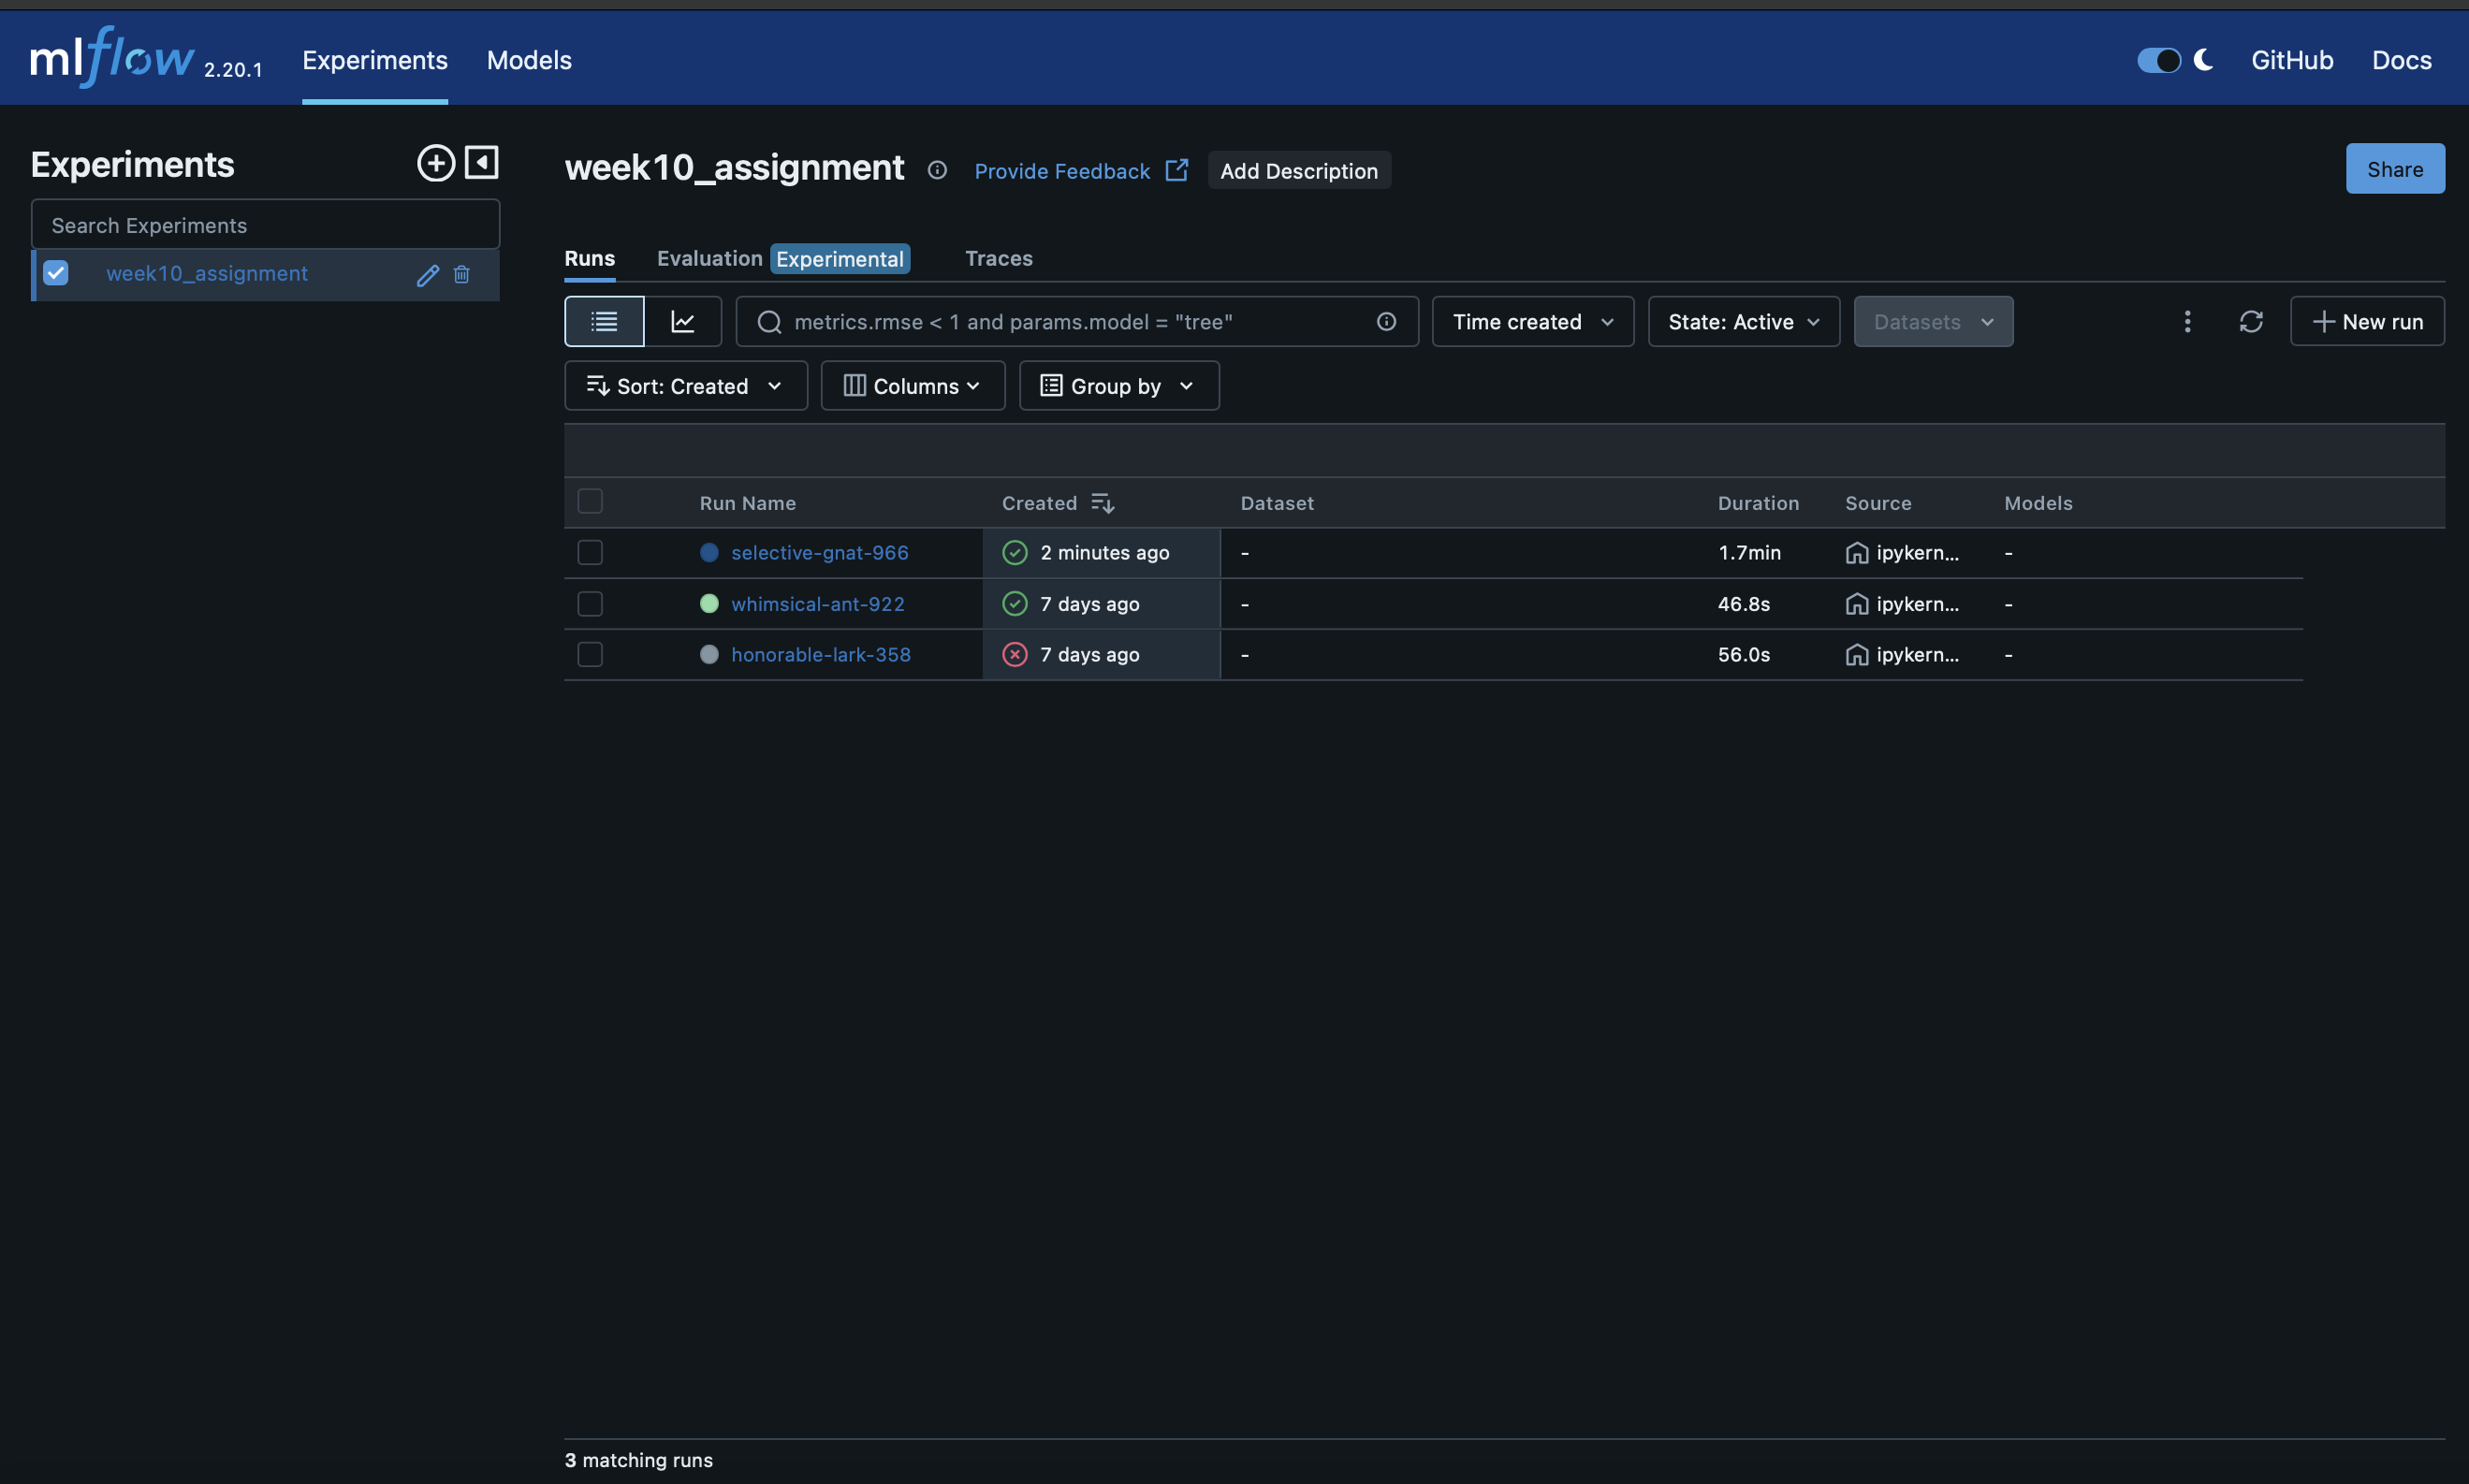

We can see all the `parameters` and `metrics` captured by MLFlow as defined in `log_params` and `log_metrics` functions.

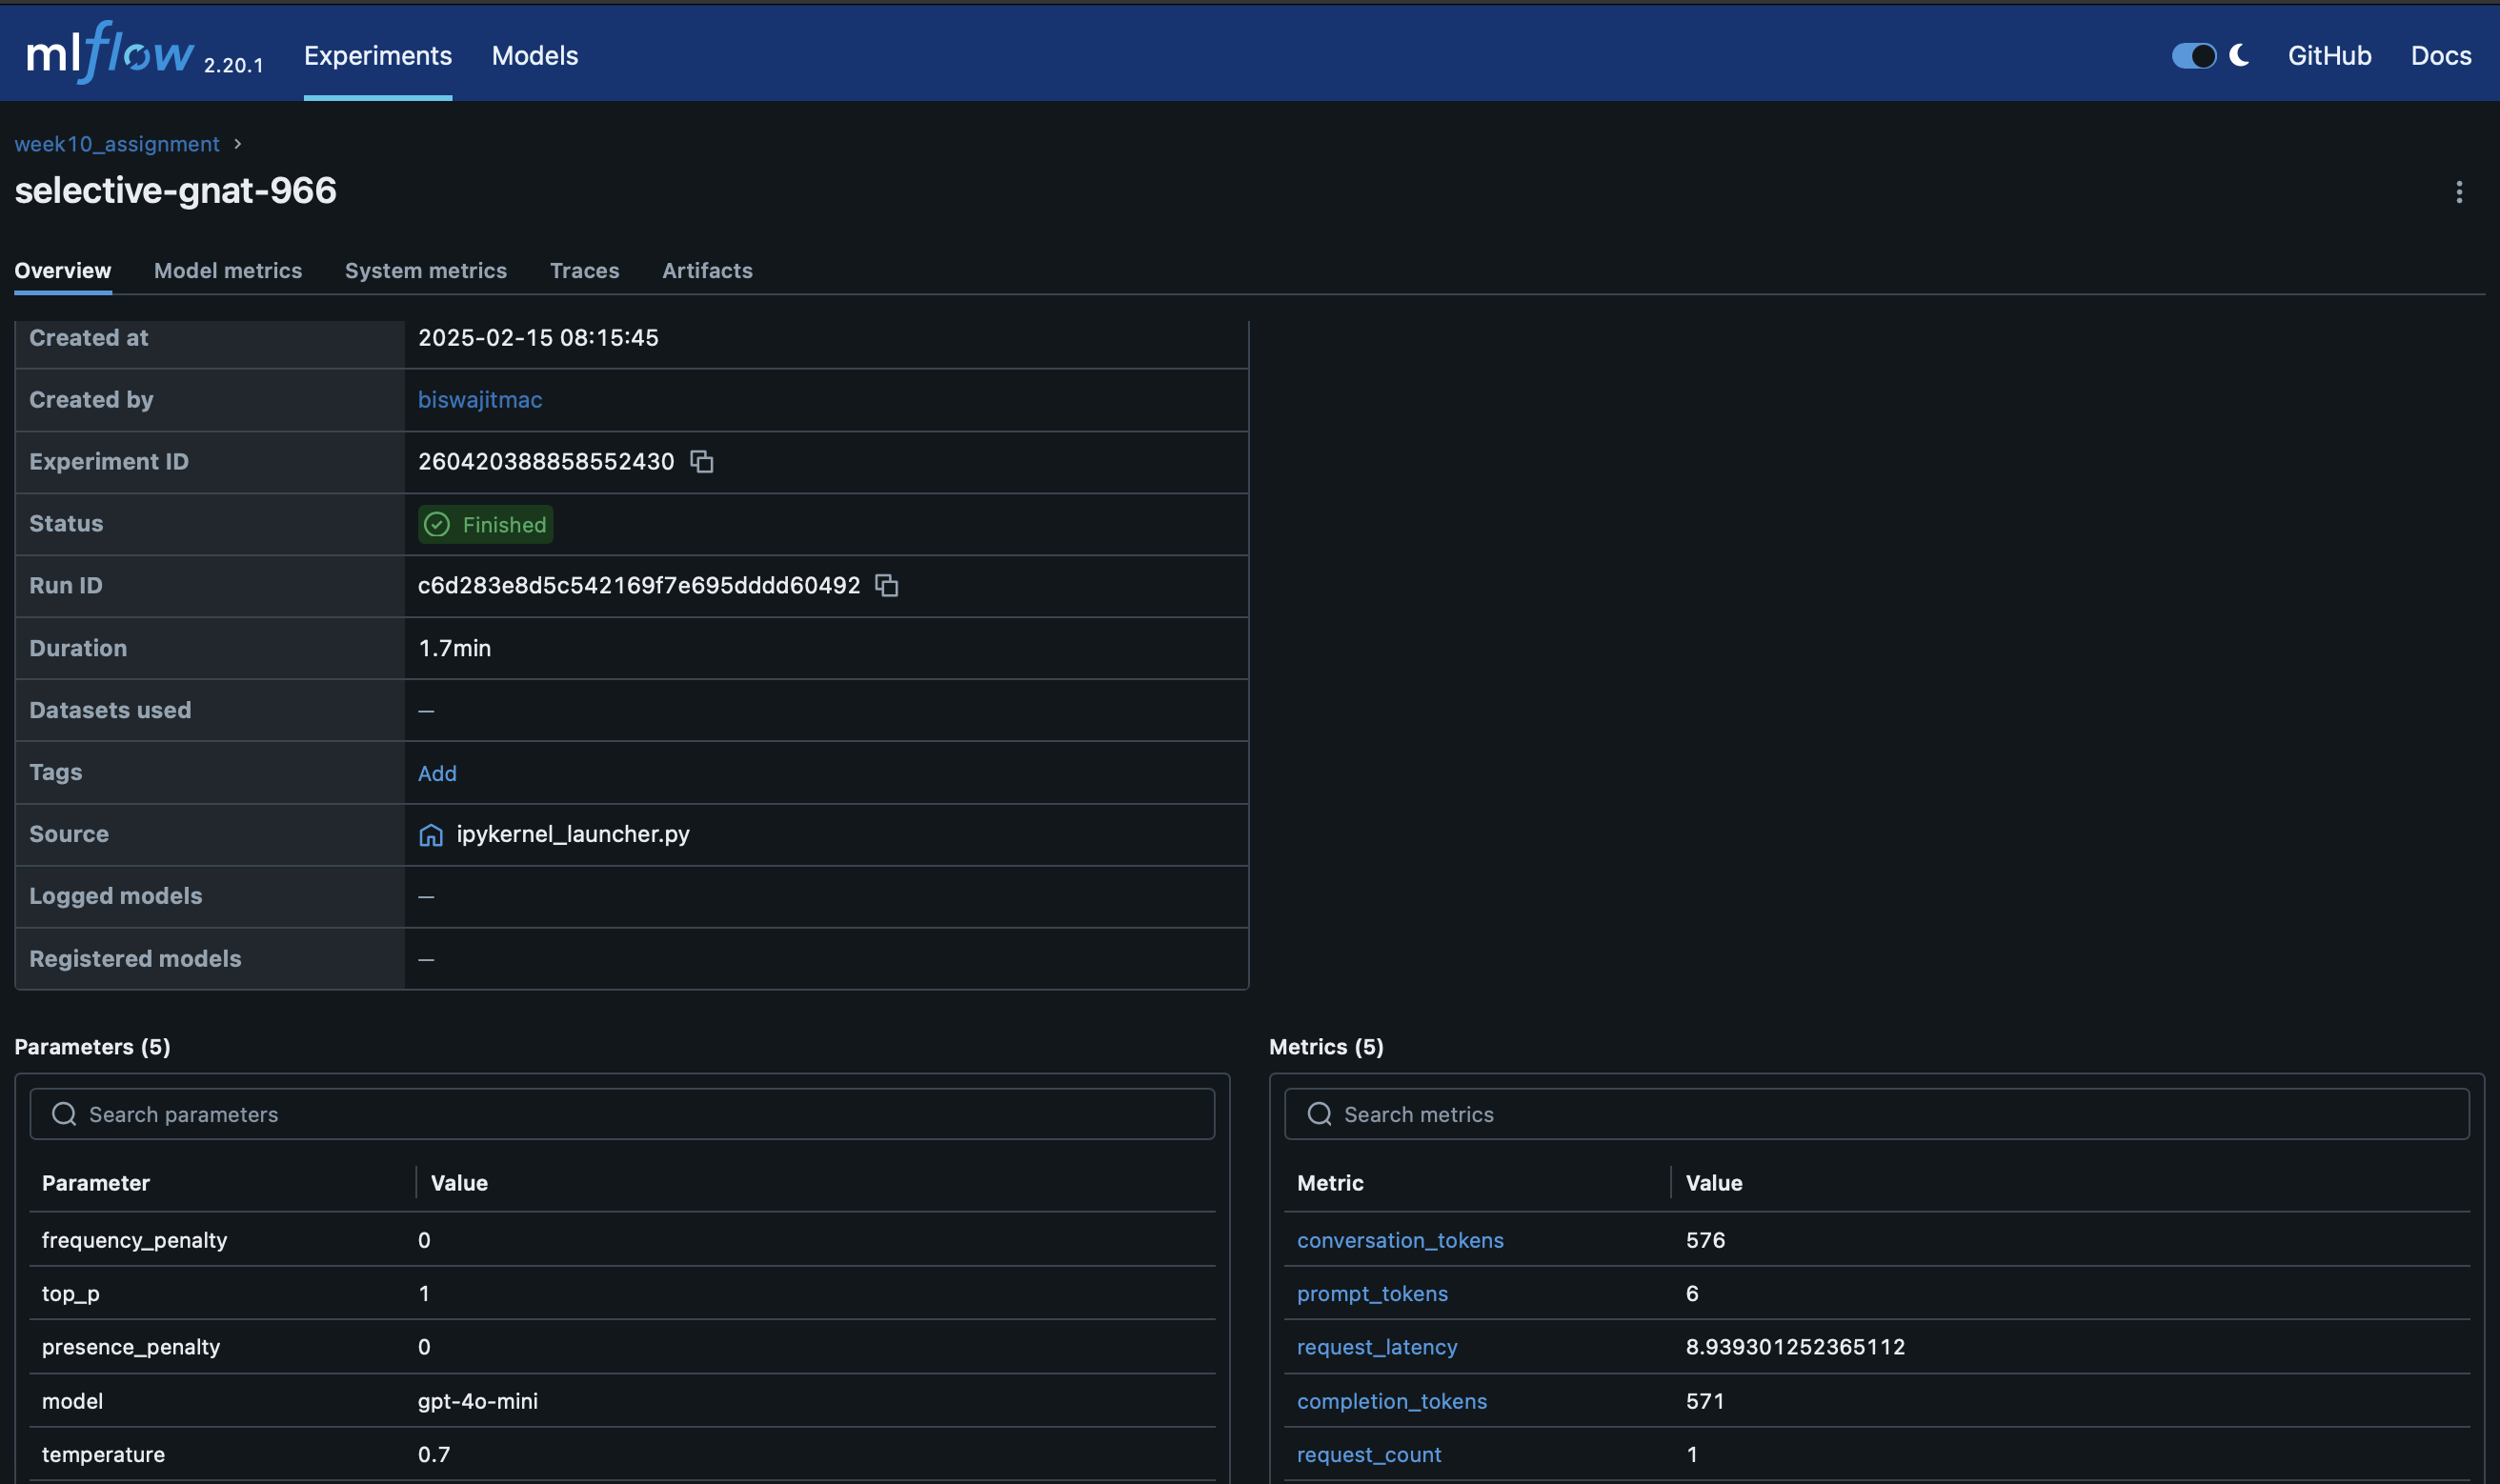

We see that for run `selective-gnat-966`, `gpt-4o-mini` model was used with $0.7$ temperature and $1$ top_p. The OpenAI api call had a lanency of about $9$ seconds and consumed $571$ completion tokens. Other parameters and metrics are also avalibale for reference.

The comparison of model metrics between runs are also avaliable as _graphical charts_ on MLFlow.

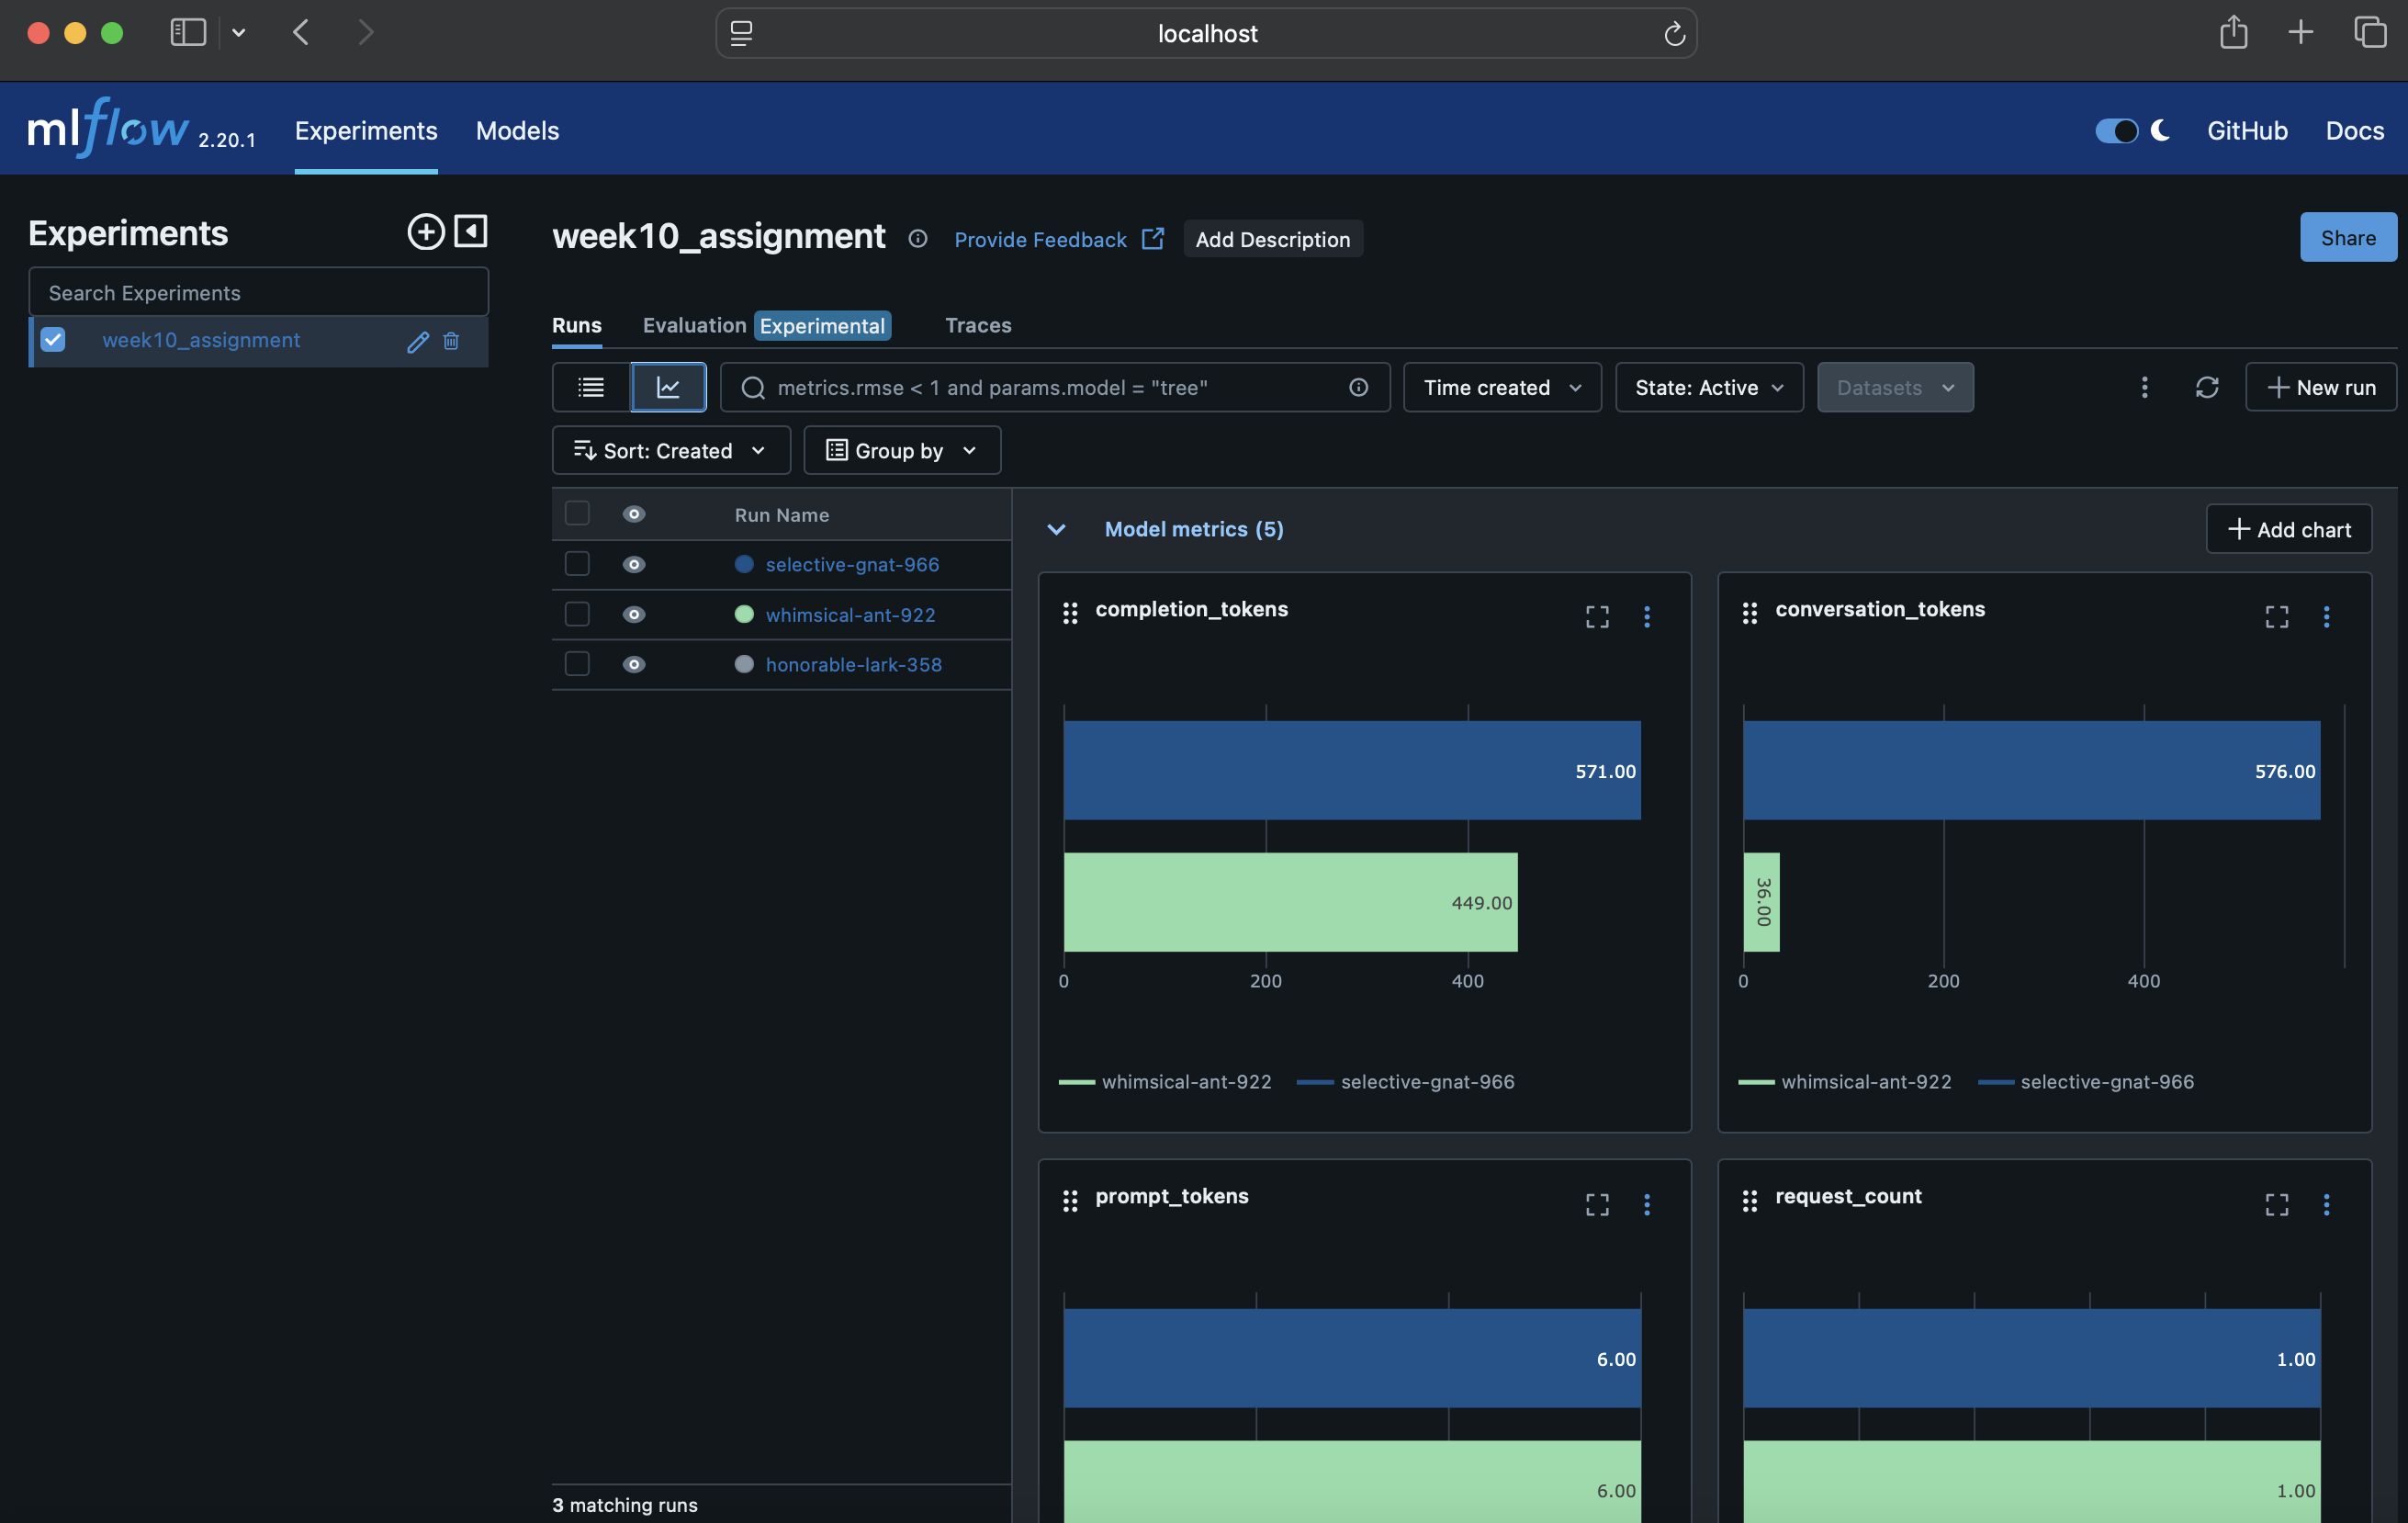
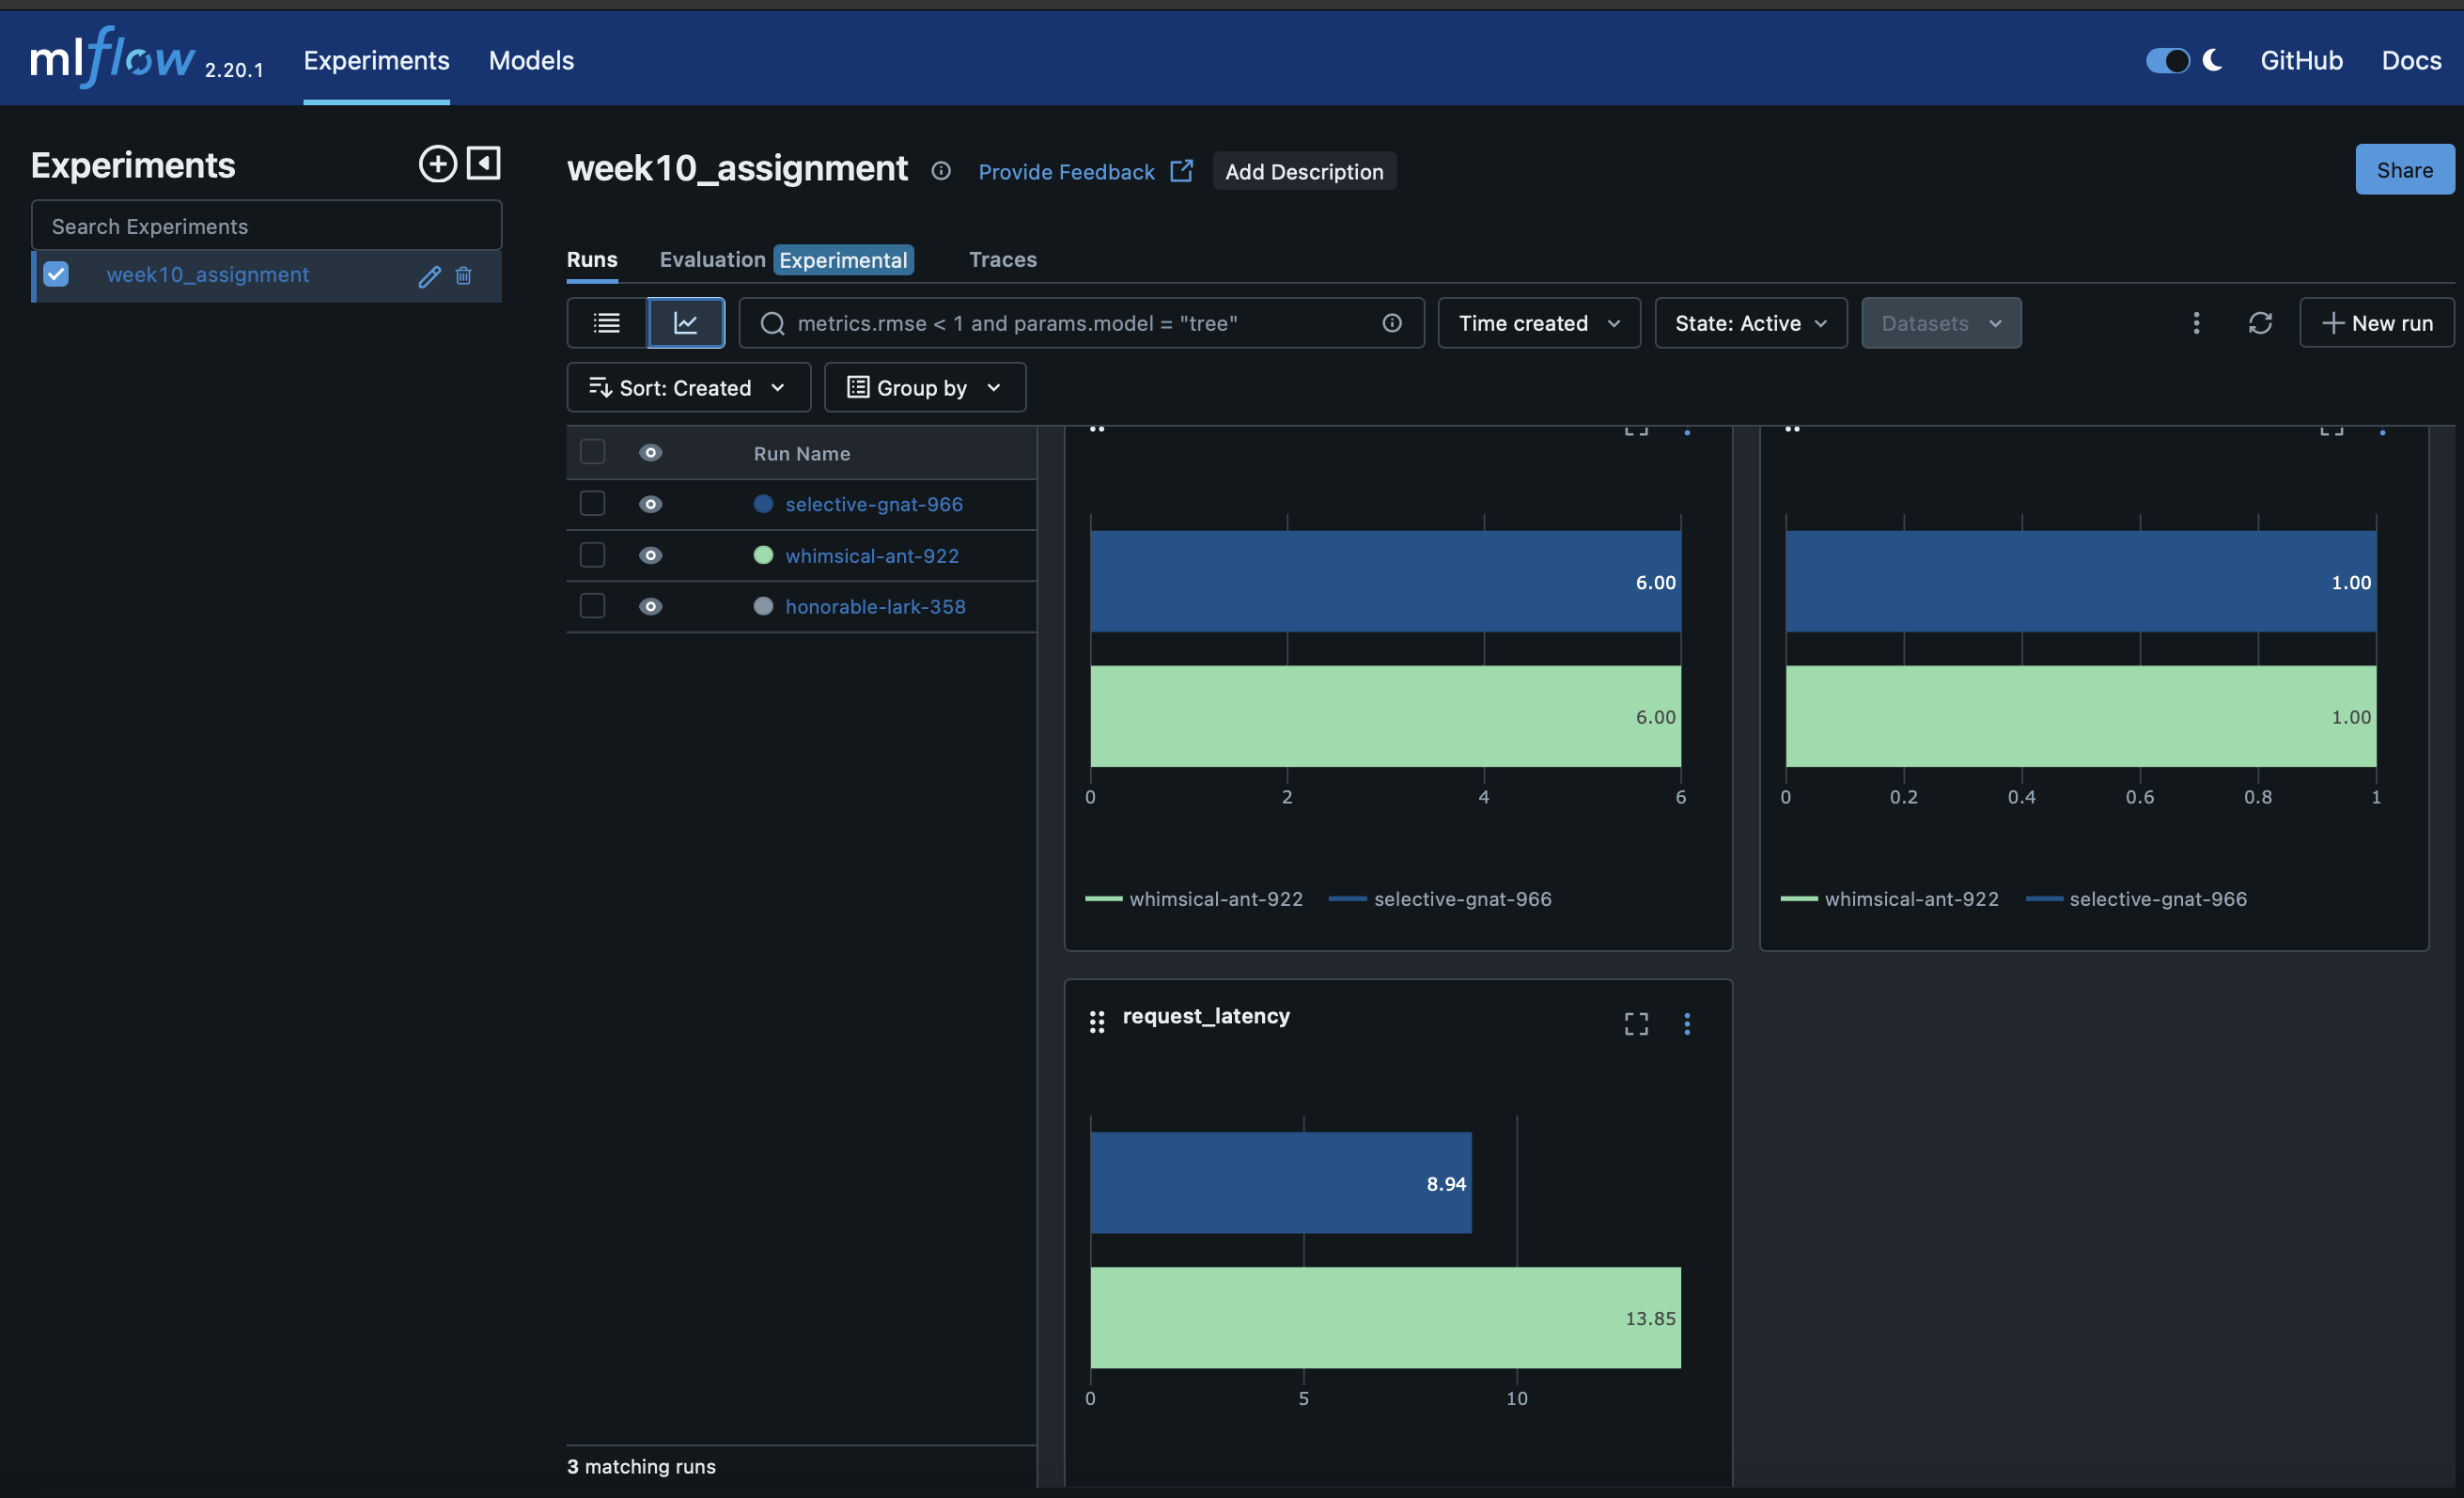

We can also see information about the request and response of the OpenAI api calls for each runs of the experiment on MLFlow

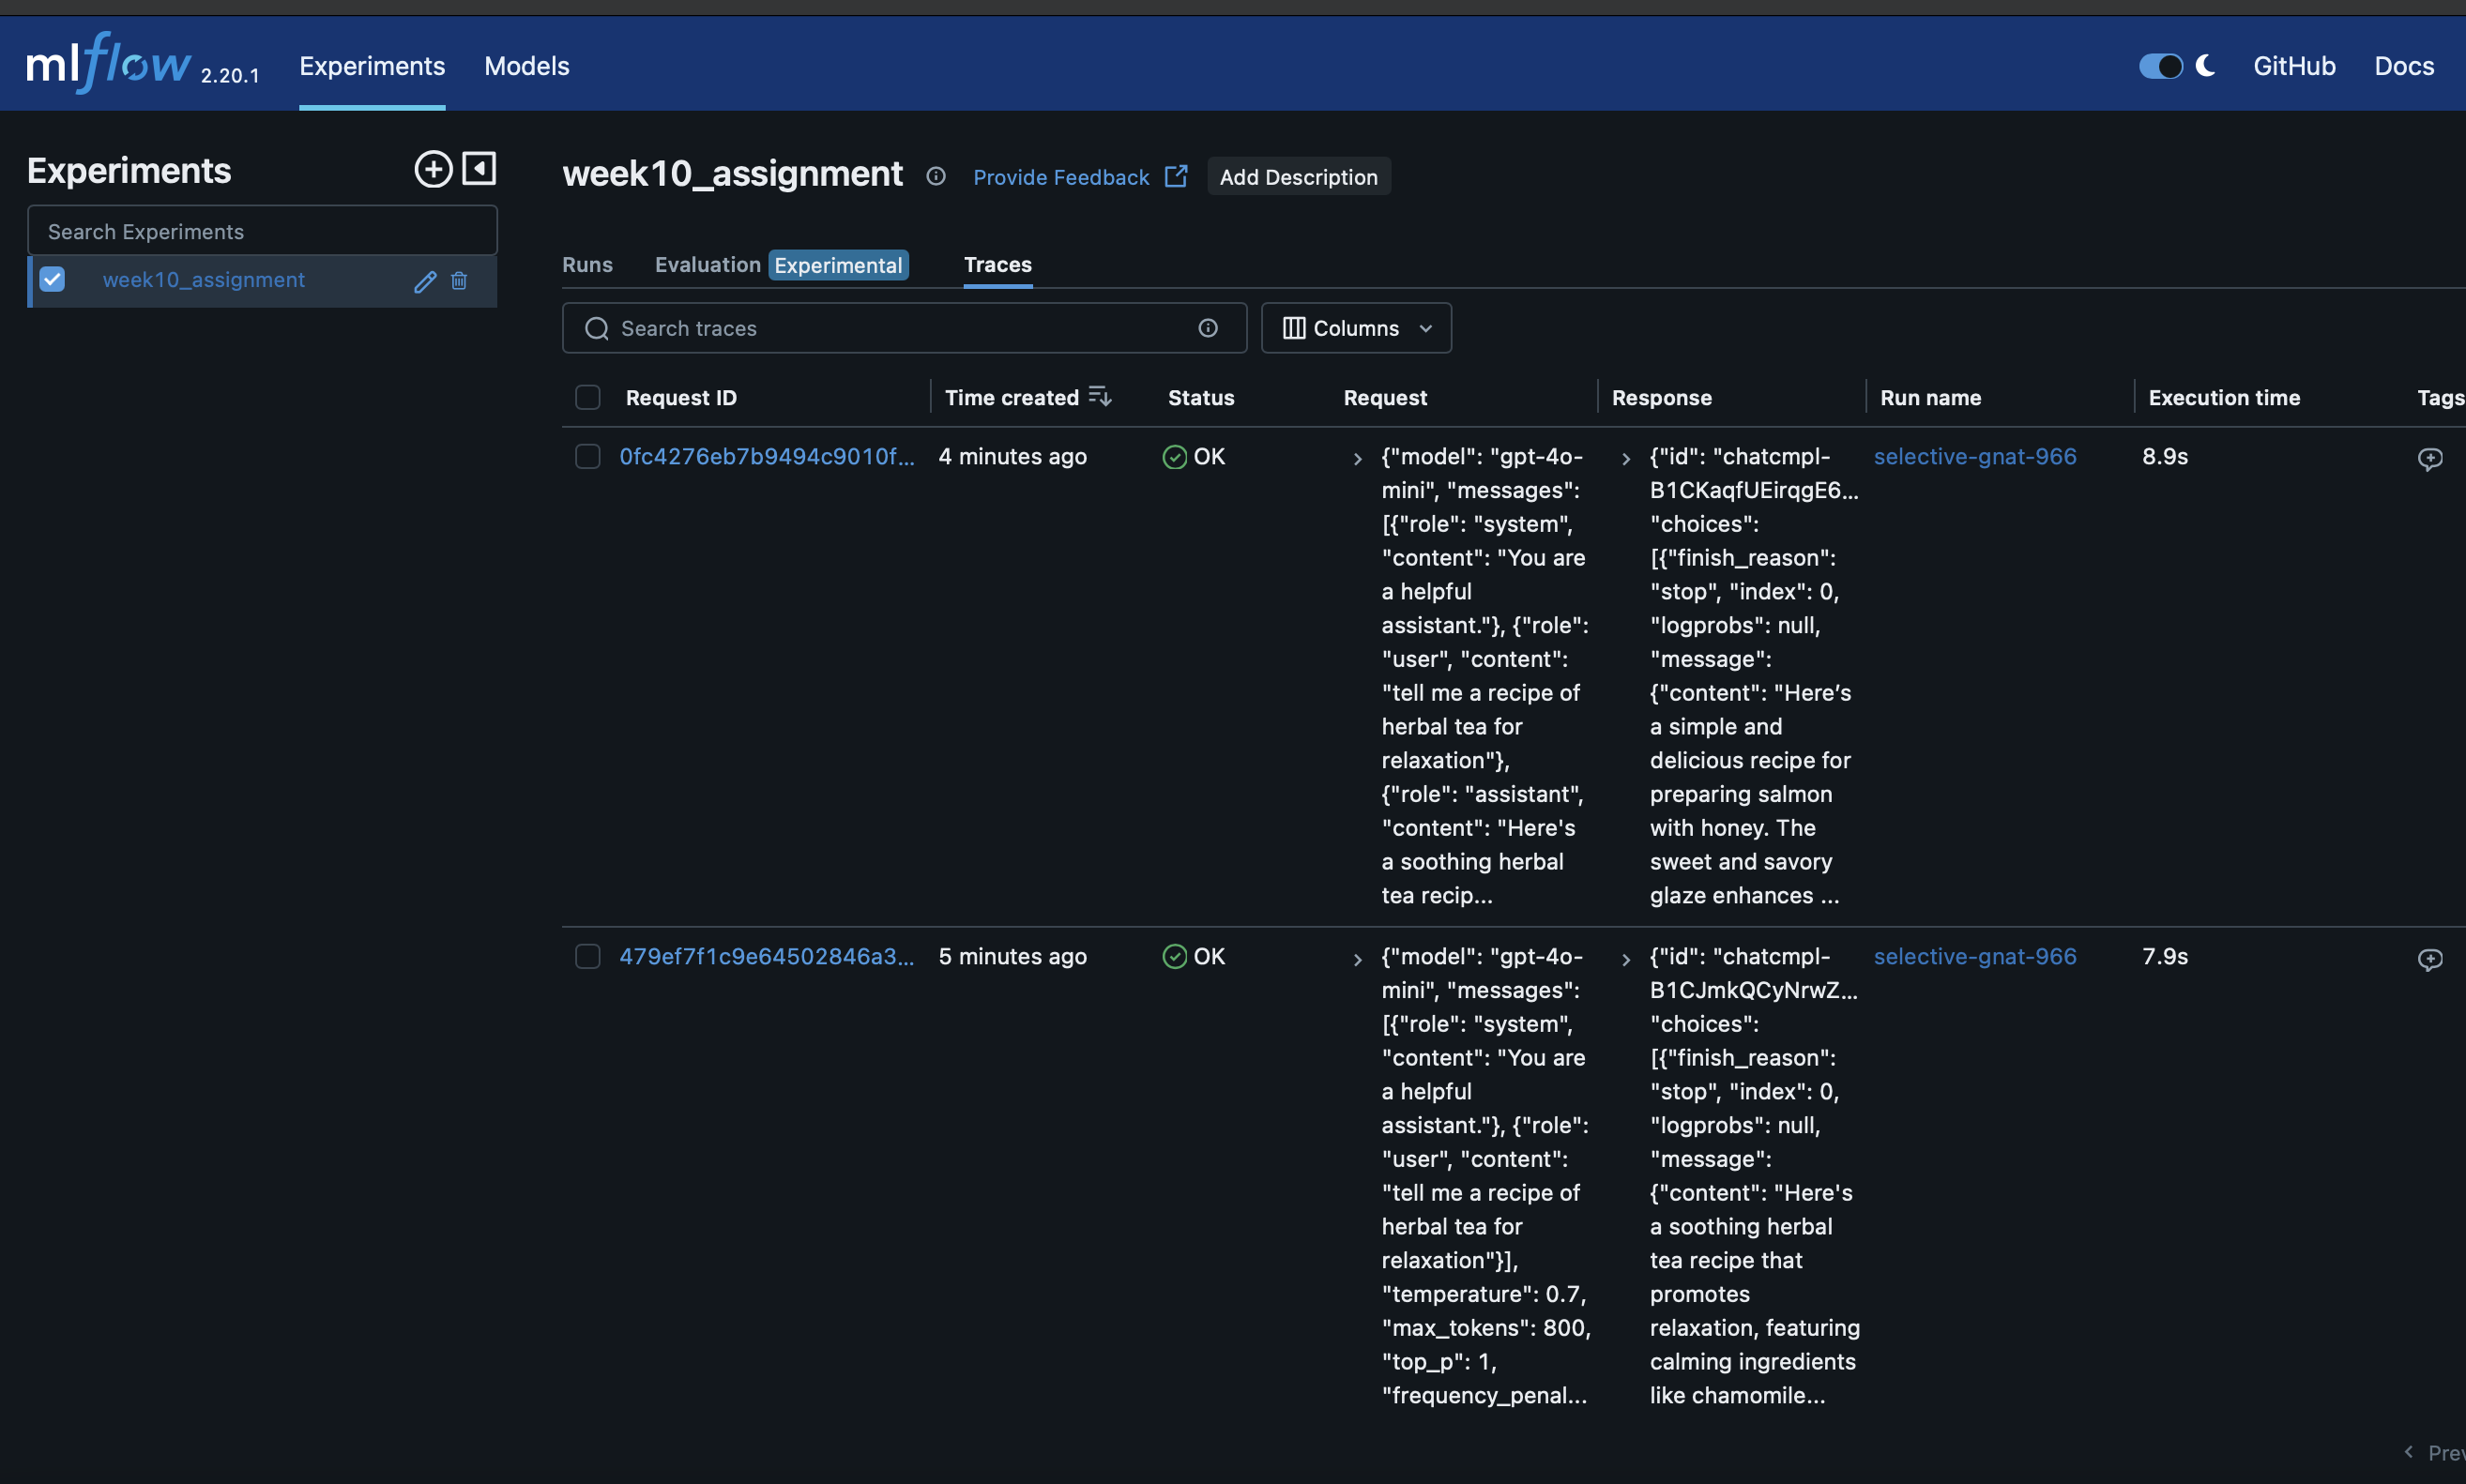